# Predict power outages in UK winter storms

This notebook extracts the training or synthetic data for a DNO licence region and season (winter) and aggregates the meteorological variables over the region. Using linear regression coefficients from [Manning *et al.* (2025)](https://doi.org/10.1038/s43247-025-02176-6), it predicts the probability of a large power outage event $P(F^N > F^N_{95})$ using a logistic regression model with predictors maximum wind gust ($v^X$), maximum deviation from prevailing wind direction at time of maximum wind gust ($d^X$), total 30-day antecedent rainfall $r^{30}$, and season.

**Note:** may need to do `python -m pip install regionmask`.

In [99]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = "monospace" #

wd = "hazGAN2/projects/poweruk_winter"

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]

Load the DNO license regions and visualise them to make sure.

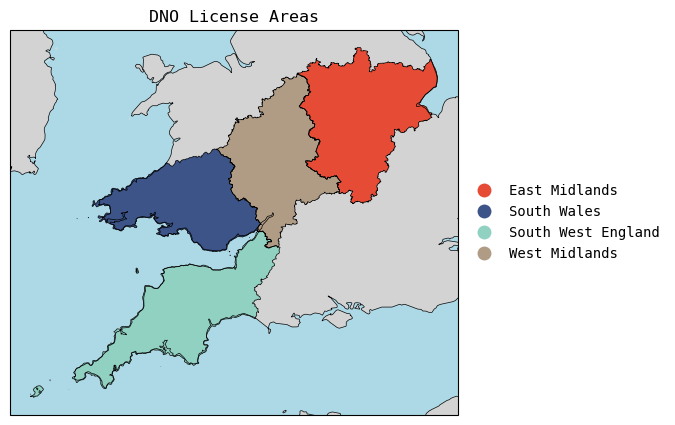

In [100]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#E64B35", "#4DBBD5", "#00A087", "#3C5488", "#F39B7F", "#8491B4", "#91D1C2", "#DC0000", "#7E6148", "#B09C85"], name='npg')

dno_path = os.path.join(wd, "resources", "dno_license_areas.geojson")

dno_regions_uk = gpd.read_file(dno_path)
dno_regions = dno_regions_uk[dno_regions_uk["region"].isin(regions)]
bbox = dno_regions.total_bounds

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(6, 5))

dno_regions.boundary.plot(color="k", ax=ax, linewidth=0.5)
dno_regions.plot("region", ax=ax, categorical=True, legend=True, cmap=cmap,
                 legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "frameon": False})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

ax.set_title("DNO License Areas");

fig.savefig(os.path.join(wd, "results", "figures", "dno_regions"), dpi=300, transparent=True)

Load the real and synthetically generated data. Optionally subset by the maximum gust speed. For now, let this depend on whether this subset was used during training.

In [101]:
train = xr.open_dataset(os.path.join(wd, "results", "training", "data.nc"))
print(train.sizes)

Frozen({'time': 429, 'lat': 64, 'lon': 64, 'field': 3, 'month': 3, 'param': 6})


In [102]:
gener = xr.open_dataset(os.path.join(wd, "results", "generated", "netcdf", "data.nc"), engine="netcdf4")
gener.load() # do the expensive server load once
print(gener.sizes)

Frozen({'time': 14100, 'lat': 64, 'lon': 64, 'field': 3, 'param': 6})


Decide whether to do the analysis for the training or synthetic data.

In [106]:
dataset = ["training", "generated"][1]
data = train.copy() if dataset == "training" else gener.copy()

For the analysis, we want absolute deviation from the prevailing wind direction but we want the absolute values of wind and rainfall... not the anomalies.

In [107]:
medians = train["medians"].mean(dim="month")
medians = medians.to_dataset(name="medians")

From the generated data, derive the variables of interest: wind gust speed and direction.

In [108]:
def direction(
        ds:xr.Dataset, u:str, v:str,
        params={}
        ) -> xr.DataArray:
    u = ds[u]
    v = ds[v]
    direction = (180 + 180 / np.pi * xr.ufuncs.arctan2(v, u)) % 360
    direction -= 180 # because these are anomalies
    return direction


def derive_variables(ds):
    ds["vx"] = xr.ufuncs.hypot(ds.u10, ds.v10)
    ds["dx"] = direction(ds, "u10", "v10")
    return ds

data["u10"] = data.sel(field="u10_gust").anomaly
data["v10"] = data.sel(field="v10_gust").anomaly
data["r30"] = data.sel(field="r30").anomaly

medians["u10"] = medians.sel(field="u10_gust").medians
medians["v10"] = medians.sel(field="v10_gust").medians
medians["r30"] = medians.sel(field="r30").medians

print("Deriving variables...")
data = derive_variables(data)
medians = derive_variables(medians)

# convert anomalies to analysis-ready
data["vx"] += medians["vx"]
data["dx"] = data["dx"].__abs__()
data["r30"] += medians["r30"]

Deriving variables...


In [109]:
# assign units to variables
data.vx.attrs["units"] = "m/s"
data.dx.attrs["units"] = "Δ°"
data.r30.attrs["units"] = "m"

# assign long names to variables
data.vx.attrs["long_name"] = "10m gust speed"
data.dx.attrs["long_name"] = "10m wind direction anomaly"
data.r30.attrs["long_name"] = "30-day accumulated precipitation"

Slightly experimental... ideally this would be done with full climatology. But let's calculate the 98th percentile across all variables.

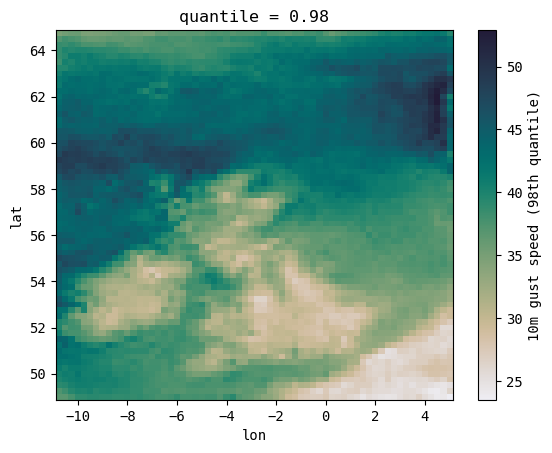

In [118]:
data["vx_98"] = data.vx.quantile(0.98, dim="time")
data["dx_98"] = data.dx.quantile(0.98, dim="time")
data["r30_98"] = data.r30.quantile(0.98, dim="time")

# assign long names to variables
data.vx_98.attrs["long_name"] = "10m gust speed (98th quantile)"
data.dx_98.attrs["long_name"] = "10m wind direction anomaly (98th quantile)"
data.r30_98.attrs["long_name"] = "30-day accumulated precipitation (98th quantile)"

data.vx_98.plot(cmap=cmo.rain)

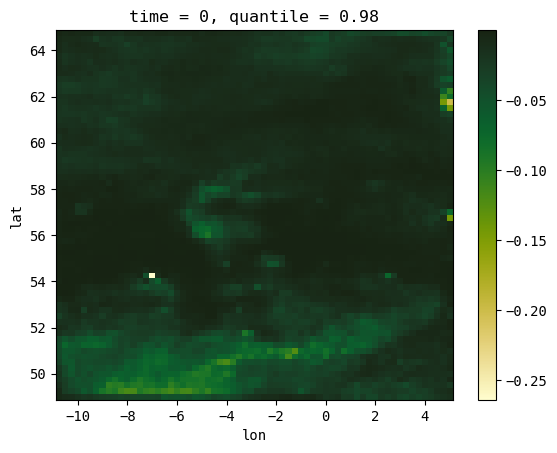

In [127]:
ssi = (((data.vx.isel(time=0) / data.vx_98) - 1)**3)
ssi.plot(cmap=cmo.speed)

Visualise these for a random time over the DNO licence region of interest (`region_of_interest`).

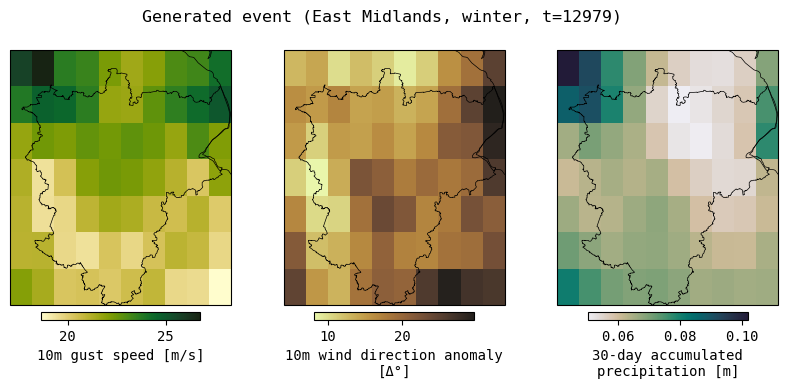

In [119]:
# %% crop to license area
t = np.random.randint(data.sizes["time"])

data_t = data.isel(time=t)

dno_region = dno_regions[dno_regions["region"] == region_of_interest]
dno_buffered = dno_region.to_crs(27700).buffer(1500).to_crs(4326)
dno_bbox = dno_buffered.total_bounds

lon_mask = (data_t.lon >= dno_bbox[0]) & (data_t.lon <= dno_bbox[2])
lat_mask = (data_t.lat >= dno_bbox[1]) & (data_t.lat <= dno_bbox[3])

data_region = data_t.isel(lon=lon_mask, lat=lat_mask)

fig, axs = plt.subplots(1, 3, figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})

cbar_kws = {"shrink": 0.7, "pad": 0.02, "orientation": "horizontal"}

data_region.vx.plot(ax=axs[0], cmap=cmo.speed, cbar_kwargs=cbar_kws)
data_region.dx.plot(ax=axs[1], cmap=cmo.turbid, cbar_kwargs=cbar_kws)
data_region.r30.plot(ax=axs[2], cmap=cmo.rain, cbar_kwargs=cbar_kws)

for ax in axs:
    dno_region.boundary.plot(color="k", ax=ax, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_title("")

fig.suptitle(f"{dataset.capitalize()} event ({region_of_interest}, {season}, {t=})", fontsize=12);

fig.savefig(os.path.join(
    wd, "results", "figures", f"sample_{region_of_interest.lower()}_{season}_{dataset}"
), dpi=300, transparent=True)


We need to extract values intersecting the DNO licence region, and aggregate them (mean or max) over the region.

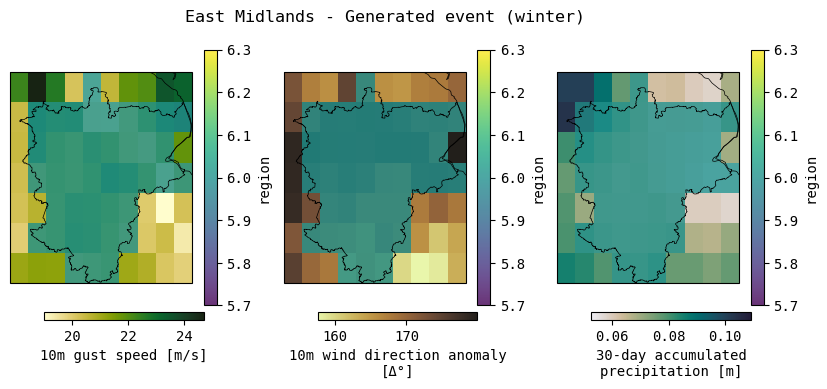

In [77]:
# %% intersect with license areas
lon = data_region.lon.values
lat = data_region.lat.values

dno_mask = mask_geopandas(dno_buffered, lon, lat)
data_region["dno_mask"] = dno_mask

fig, axs = plt.subplots(1, 3, figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})

cbar_kws = {"shrink": 0.7, "pad": 0.02, "orientation": "horizontal"}

data_region.vx.plot(ax=axs[0], cmap=cmo.speed, cbar_kwargs=cbar_kws)
data_region.dx.plot(ax=axs[1], cmap=cmo.turbid, cbar_kwargs=cbar_kws)
data_region.r30.plot(ax=axs[2], cmap=cmo.rain, cbar_kwargs=cbar_kws)

for ax in axs:
    dno_region.boundary.plot(color="k", ax=ax, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    data_region.dno_mask.plot(alpha=0.8, ax=ax)
    ax.set_title("")

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} event ({season})", fontsize=12);

In [78]:
# create a mask for xarray
data["dno_mask"] = mask_geopandas(dno_buffered, data.lon, data.lat)
data["dno_mask"] = data["dno_mask"].notnull()

In [79]:
absmean = lambda x, axis=None, **kwargs: np.nanmean(np.abs(x), axis=axis)

agg_funcs = {"vx": "max", "dx": absmean, "r30": "mean"}

data_masked = data.where(data.dno_mask) 

data_agg = xr.Dataset()
for var, func in agg_funcs.items():
    if callable(func):
        # Use skipna=True to ignore NaN values outside the mask
        data_agg[var] = data_masked[var].reduce(func, dim=['lat', 'lon'], skipna=True)
    else:
        # Built-in methods like max, mean
        data_agg[var] = getattr(data_masked[var], func)(dim=['lat', 'lon'], skipna=True)

# Compute with progress bar
from dask.diagnostics import ProgressBar
with ProgressBar():
    data_agg = data_agg.compute()

print(data_agg)

# add units and long names
for var in agg_funcs.keys():
    data_agg[var].attrs["units"] = data[var].attrs["units"]
    data_agg[var].attrs["long_name"] = data[var].attrs["long_name"]

<xarray.Dataset> Size: 451kB
Dimensions:  (time: 14100)
Coordinates:
  * time     (time) int64 113kB 0 1 2 3 4 5 ... 14095 14096 14097 14098 14099
Data variables:
    vx       (time) float64 113kB 23.68 16.38 28.26 22.44 ... 29.76 20.82 33.36
    dx       (time) float64 113kB 46.37 55.98 141.8 57.03 ... 104.1 147.9 170.0
    r30      (time) float64 113kB 0.03487 0.07725 0.09056 ... 0.05572 0.119


So you end up with some samples where $v^X$ across the region is now less than 20 mps. Need to mask it all over again... probably just shouldn't bother in the previous cell.

In [80]:
if config["event_subset"]["do"]:
    print("Subsetting...")
    threshold = config["event_subset"]["value"]
    mask = data_agg.vx > threshold
    
    print(f"Found {mask.sum().values} events")
    data_agg = data_agg.isel(time=mask)

    assert data_agg.vx.min() >= 20, "masking didn't work!"

Subsetting...
Found 9312 events


Let's look at the distribution of the anomalies over the license area.

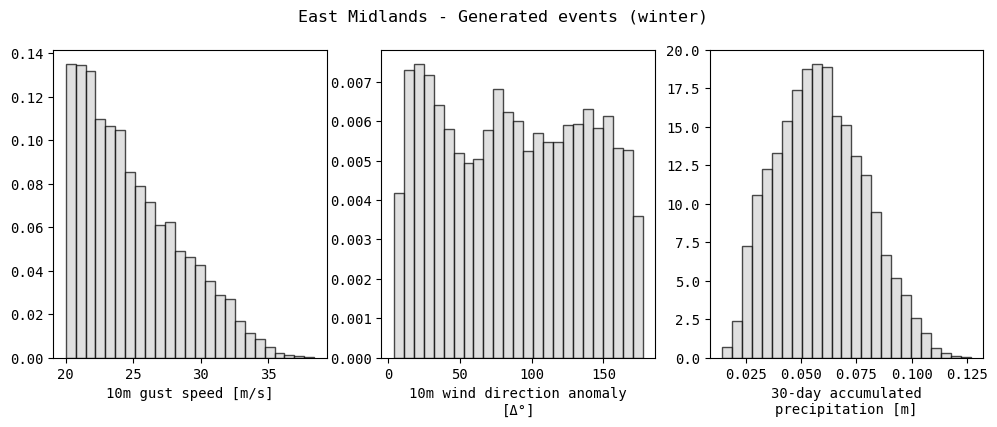

In [81]:
hist_kws = {"density": True, "alpha": 0.7, "bins": 25,  "color": "lightgrey", "edgecolor": "k"}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

data_agg.vx.plot.hist(ax=axs[0], **hist_kws)
data_agg.dx.plot.hist(ax=axs[1], **hist_kws)
data_agg.r30.plot.hist(ax=axs[2], **hist_kws);

for ax in axs:
    ax.set_title("")

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} events ({season})", fontsize=12);

Finally, we can use the regression coefficients from Manning *et al.* (2025) to predict the probability of a large power outage $P(F > F^{95})$ during each storm.


Wind-only (East Midlands):

Coefficient (β₁) ≈ -7.99557966729893 (per m/s)

Intercept (β₀) ≈ 0.273404018018712

This gives a relatively gentle slope, consistent with the gradual S-curve shown.

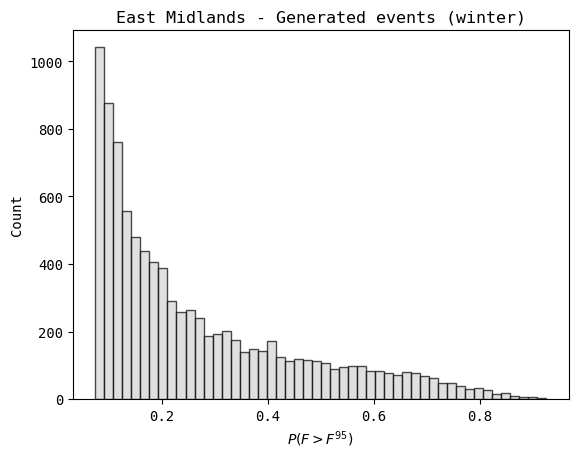

In [82]:
X0 = np.hstack([
    np.ones(data_agg.vx.shape).reshape(-1, 1),
    data_agg.vx.values.reshape(-1, 1)
])

base_coefs = np.array([-7.99557966729893, 0.273404018018712])
base_probs = expit(np.dot(X0, base_coefs))

data_agg["base_probs"] = (("time"), base_probs)

hist_kws = {"density": False, "alpha": 0.7, "bins": 50,  "color": "lightgrey", "edgecolor": "k"}

plt.hist(base_probs, **hist_kws)
plt.title(f"{region_of_interest} - {dataset.capitalize()} events ({season})", fontsize=12)
plt.ylabel("Count")
plt.xlabel(r"$P(F>F^{95})$");

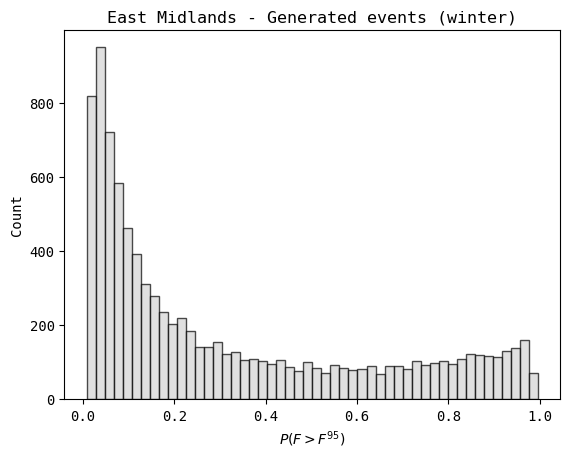

In [83]:
# %% load the coefs
coefs = pd.read_csv(os.path.join(wd, "resources/E_Mid_All_Variable_Model_coefficients_wind-thresh=20.csv"))

X = np.hstack([
    np.ones(data_agg.vx.shape).reshape(-1, 1),
    data_agg.vx.values.reshape(-1, 1),
    data_agg.r30.values.reshape(-1, 1),
    data_agg.dx.values.reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1),
    np.zeros(data_agg.vx.shape).reshape(-1, 1)
    ])

probs = expit(np.dot(X, coefs["Coefficients"].values))
data_agg["outage_prob"] = (("time"), probs)

hist_kws = {"density": False, "alpha": 0.7, "bins": 50,  "color": "lightgrey", "edgecolor": "k"}

plt.hist(probs, **hist_kws)
plt.title(f"{region_of_interest} - {dataset.capitalize()} events ({season})", fontsize=12)
plt.ylabel("Count")
plt.xlabel(r"$P(F>F^{95})$");

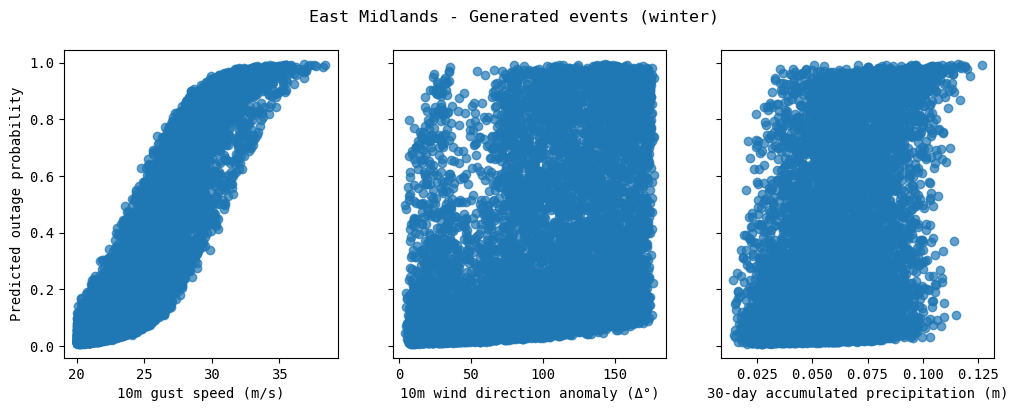

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

ax = axs[0]
ax.scatter(data_agg.vx, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.vx.long_name + f" ({data_agg.vx.units})")

ax = axs[1]
ax.scatter(data_agg.dx, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.dx.long_name + f" ({data_agg.dx.units})")

ax = axs[2]
ax.scatter(data_agg.r30, data_agg.outage_prob, alpha=0.7)
ax.set_xlabel(data_agg.r30.long_name + f" ({data_agg.r30.units})")

for ax in axs:
    ax.set_title("")
    ax.set_ylabel("Predicted outage probability")
    ax.label_outer()

fig.suptitle(f"{region_of_interest} - {dataset.capitalize()} events ({season})", fontsize=12);

#### Return period analysis in loss space

Calculated number of samples: 1430 based on 429 events over 15 years, equivalent to 95 events per year.

In [85]:
λ = 309 / 15  # samples per year
print(λ)

def return_period(outage_probs, λ):
    n = outage_probs.sizes["time"]
    ranks = outage_probs.rank(dim="time")
    survival_probs = 1 - ranks / n # sometimes (ranks-0.5) / n ... check which is better
    return_periods = 1 / (λ * survival_probs)
    return return_periods

data_agg["return_period"] = (("time"), return_period(data_agg.outage_prob, λ).data)
data_agg["base_return_period"] = (("time"), return_period(data_agg.base_probs, λ).data)

data_agg = data_agg.set_coords('return_period').sortby("return_period")

20.6


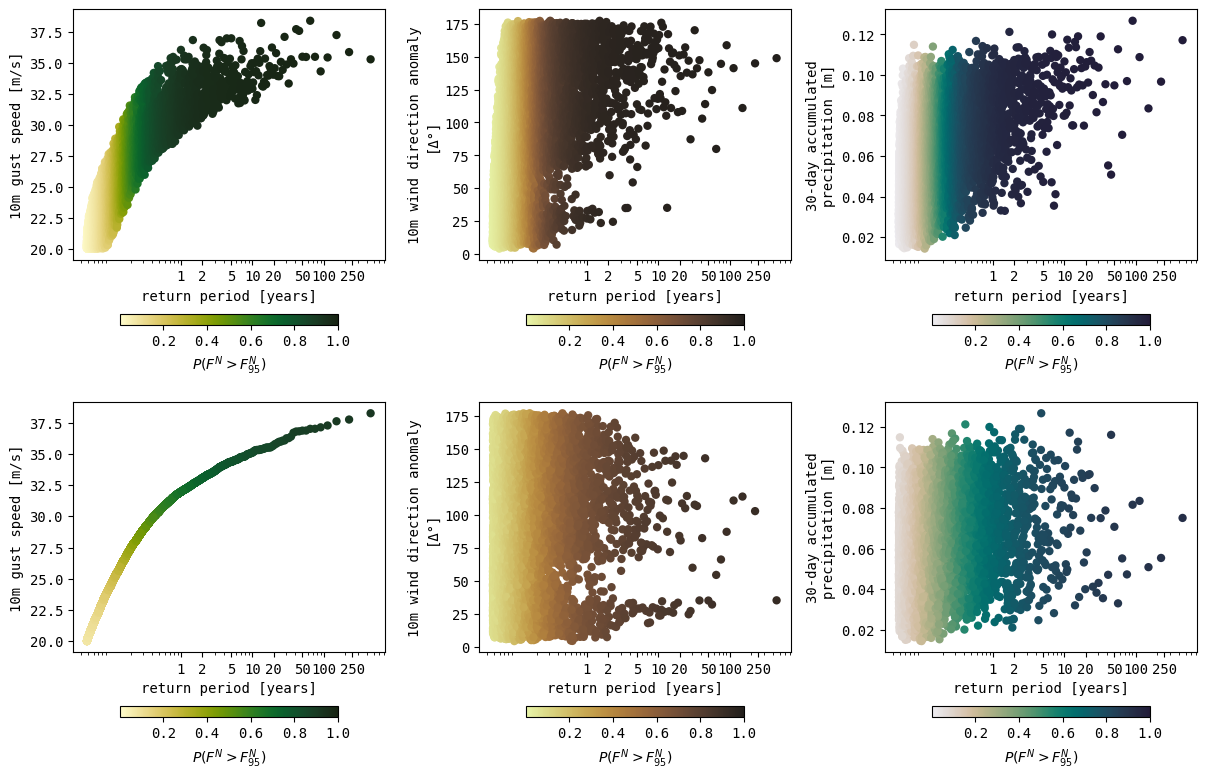

In [86]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

cbar_kws = {"shrink": 0.7, "pad": 0.15, "orientation": "horizontal", "label": r"$P(F^N>F^N_{95})$"}

kws = {"edgecolor": "none", "add_colorbar": True, "cbar_kwargs": cbar_kws, "vmin": 1e-6, "vmax": 1}

norm = LogNorm(vmin=1e-6, vmax=1)

axs = axes[0, :]
data_agg.plot.scatter(x="return_period", y="vx", hue="outage_prob", ax=axs[0], cmap=cmo.speed, **kws)
data_agg.plot.scatter(x="return_period", y="dx", hue="outage_prob", ax=axs[1], cmap=cmo.turbid, **kws)
data_agg.plot.scatter(x="return_period", y="r30", hue="outage_prob", ax=axs[2], cmap=cmo.rain, **kws)

for ax in axs.flat:
    ax.set_title("")
    ax.set_xscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
    ticks = [t for t in ticks if t <= data_agg.return_period[data_agg.return_period < np.inf].max()]
    ax.set_xticks(ticks, labels=ticks)
    ax.set_xlabel("return period [years]")


axs = axes[1, :]
data_agg.plot.scatter(x="base_return_period", y="vx", hue="base_probs", ax=axs[0], cmap=cmo.speed, **kws)
data_agg.plot.scatter(x="base_return_period", y="dx", hue="base_probs", ax=axs[1], cmap=cmo.turbid, **kws)
data_agg.plot.scatter(x="base_return_period", y="r30", hue="base_probs", ax=axs[2], cmap=cmo.rain, **kws)

for ax in axs.flat:
    ax.set_title("")
    ax.set_xscale("log")
    ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
    ticks = [t for t in ticks if t <= data_agg.base_return_period[data_agg.base_return_period < np.inf].max()]
    ax.set_xticks(ticks, labels=ticks)
    ax.set_xlabel("return period [years]")

fig.tight_layout()
fig.savefig(os.path.join(
    wd, "results", "figures", f"outage_probs_{region_of_interest.lower()}_{season}_{dataset}"),
           dpi=300, transparent=True, bbox_inches="tight")



Plot a single risk profile. This is what we will be using to compare 100-year return period events etc.

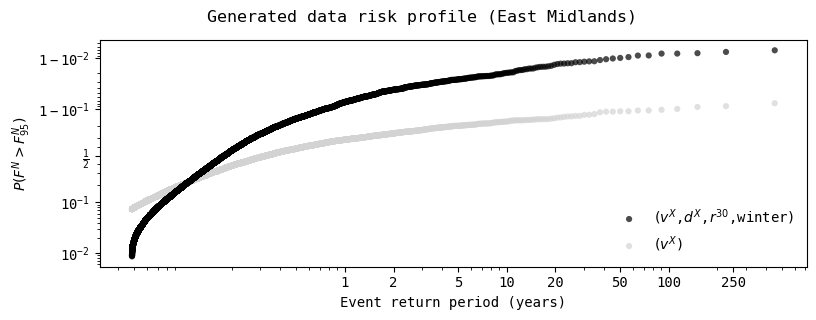

In [87]:
fig, ax = plt.subplots(1, figsize=(8, 3))

data_agg.plot.scatter(x="return_period", y="outage_prob", ax=ax, edgecolor="none", color="k",
                      s=20, alpha=0.7, zorder=1, label=fr"$(v^X$,$d^X$,$r^{{30}}$,{season})")
data_agg.plot.scatter(x="base_return_period", y="base_probs", ax=ax, edgecolor="none", color="lightgrey",
                      s=20, alpha=0.7, zorder=0, label=r"$(v^X$)")

ax.set_title("")
ax.set_xscale("log")
ticks = [1, 2, 5, 10, 20, 50, 100, 250, 500, 1000]
ticks = [t for t in ticks if t <= data_agg.return_period[data_agg.return_period < np.inf].max()]
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel(r"$P(F^N>F^N_{95})$")
ax.set_xlabel("Event return period (years)")
ax.legend(loc="lower right", frameon=False)
fig.tight_layout()
ax.set_yscale("logit")

fig.suptitle(f"{dataset.capitalize()} data risk profile ({region_of_interest})", y=1.05);

fig.savefig(os.path.join(
    wd, "results", "figures", f"riskprofile_{region_of_interest.lower()}_{season}_{dataset}"),
           dpi=300, transparent=True, bbox_inches="tight")

os.makedirs(os.path.join(wd, "analysis", "data"), exist_ok=True)
data_agg.to_netcdf(os.path.join(
    wd, "analysis", "data", f"risk_profile_{region_of_interest.lower()}_{dataset}_{season}.nc")
)

#### Further analysis
1. View some of the most severe storms
1. Compare the risk profiles for train and generated data

In [91]:
n = 5

top_n = data_agg.sortby("return_period").isel(time=slice(-(n+1), -1))
top_n_times = top_n.time
top_n_return_periods = top_n.return_period
top_n_outage_probs = top_n.outage_prob

# switch from [data, data_region] to zoom in and out
top_n_events = data.sel(time=top_n_times)

lon_mask = (top_n_events.lon >= dno_bbox[0]) & (top_n_events.lon <= dno_bbox[2])
lat_mask = (top_n_events.lat >= dno_bbox[1]) & (top_n_events.lat <= dno_bbox[3])

top_n_events_zoom = top_n_events.isel(lon=lon_mask, lat=lat_mask)

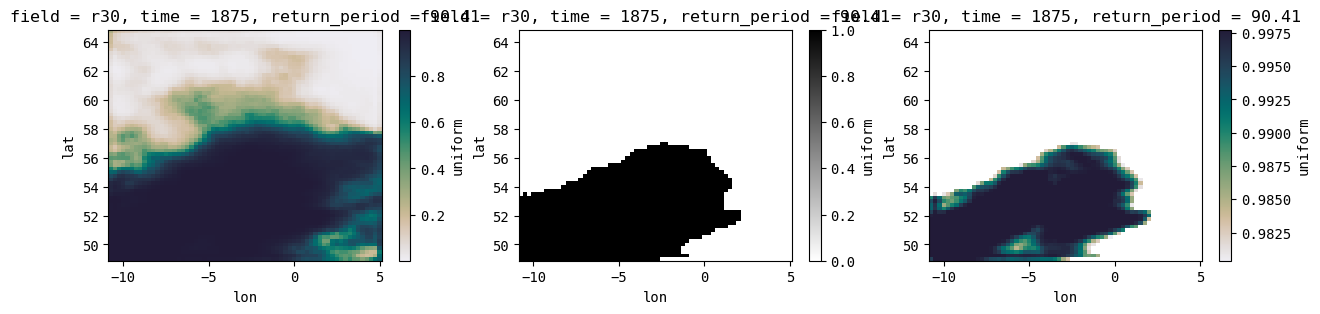

In [96]:
# vx_mask = 
q = 0.98
mask = events_to_plot["uniform"].sel(field="r30") > q

fig, axs = plt.subplots(1, 3, figsize=(15,3))
events_to_plot["uniform"].sel(field="r30").isel(time=0).plot(ax=axs[0], cmap=cmo.rain)
mask.isel(time=0).plot(ax=axs[1], cmap="binary")
events_to_plot.where(mask)["uniform"].sel(field="r30").isel(time=0).plot(ax=axs[2], cmap=cmo.rain)

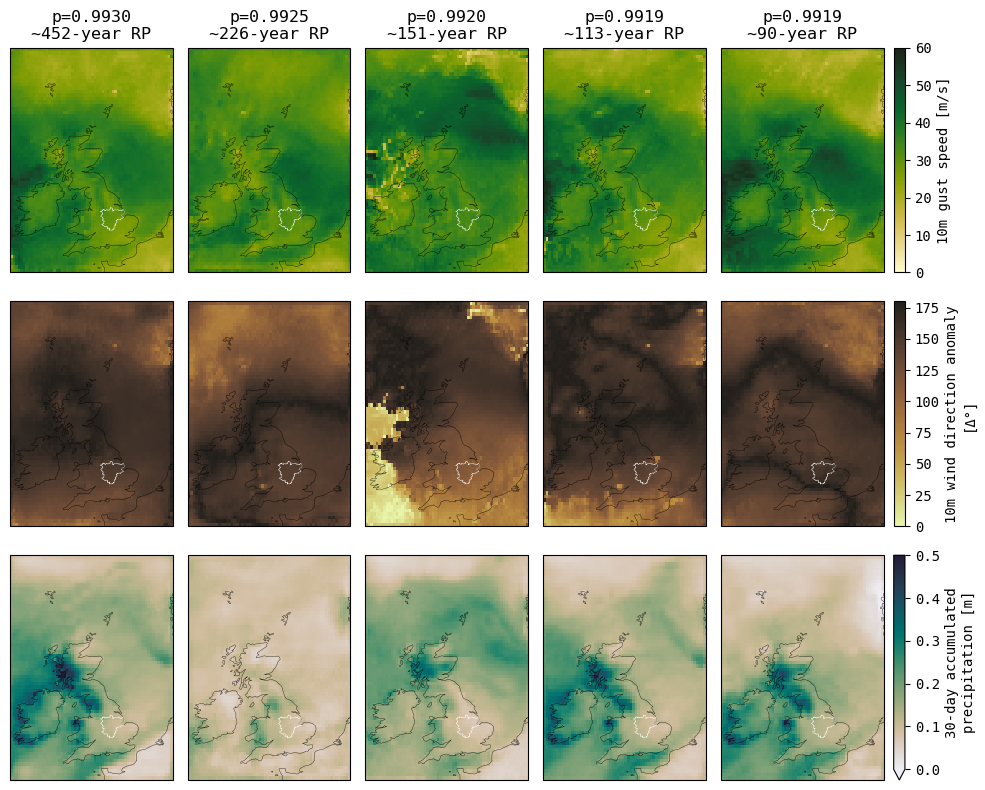

In [98]:
q = 0.5
events_to_plot = [top_n_events, top_n_events_zoom][0]

footprint_mask = events_to_plot["uniform"] > q
# events_to_plot = events_to_plot.where(footprint_mask)

fig, axes = plt.subplots(3, n, figsize=(10, 8),
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1]*(n-1) + [1.25]}
                        )

# vmins = [events_to_plot[var].min(dim=["lon", "lat", "time"]).item() for var in ["vx", "dx", "r30"]]
# vmaxs = [events_to_plot[var].max(dim=["lon", "lat", "time"]).item() for var in ["vx", "dx", "r30"]]
vmins = [0, 0, 0]
vmaxs = [60, 180, 0.5]

for i in range(n):
    axs = axes[:, i]
    t = -(i+1)

    is_edge_axis = i == (n-1)

    for j, var in enumerate(["vx", "dx", "r30"]):

        
        
        plot_obj = events_to_plot.isel(time=t)[var].plot(
            ax=axs[j],
            cmap=[cmo.speed, cmo.turbid, cmo.rain][j],
            vmin=vmins[j],
            vmax=vmaxs[j],
            add_colorbar=is_edge_axis # Important: Set to False
        )
    
    return_period = top_n_return_periods.isel(time=t).values.item()
    outage_prob = top_n_outage_probs.isel(time=t).values.item()

    if dataset == "training":
        date = events_to_plot.isel(time=t)["time.date"].values.item()
        title = f"p={outage_prob:.4f}\n~{return_period:.0f}-year RP\n{date}"
    elif dataset == "generated":
        title = f"p={outage_prob:.4f}\n~{return_period:.0f}-year RP"
        
    axs[0].set_title(title)
    axs[1].set_title(None)
    axs[2].set_title(None)

for ax in axes.flat:
    dno_region.boundary.plot(linewidth=0.25, color="white", ax=ax)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.25)
    ax.set_aspect('auto', adjustable=None)

plt.tight_layout()

fig.savefig(os.path.join(
    wd, "results", "figures", f"top_{n}_samples_{region_of_interest.lower()}_{season}_{dataset}"),
           dpi=300, transparent=True, bbox_inches="tight")

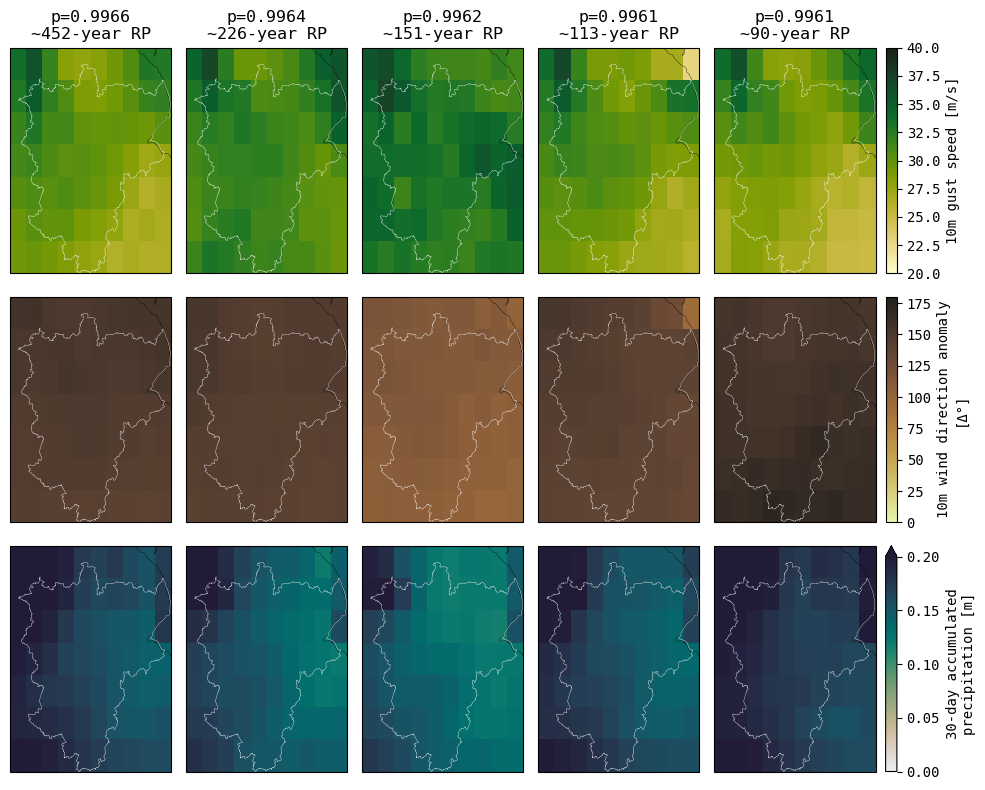

In [254]:
events_to_plot = [top_n_events, top_n_events_zoom][1]

fig, axes = plt.subplots(3, n, figsize=(10, 8),
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1]*(n-1) + [1.25]}
                        )

# vmins = [events_to_plot[var].min(dim=["lon", "lat", "time"]).item() for var in ["vx", "dx", "r30"]]
# vmaxs = [events_to_plot[var].max(dim=["lon", "lat", "time"]).item() for var in ["vx", "dx", "r30"]]
vmins = [20, 0, 0]
vmaxs = [40, 180, 0.2]

for i in range(n):
    axs = axes[:, i]
    t = -(i+1)

    is_edge_axis = i == (n-1)

    for j, var in enumerate(["vx", "dx", "r30"]):
        
        plot_obj = events_to_plot.isel(time=t)[var].plot(
            ax=axs[j],
            cmap=[cmo.speed, cmo.turbid, cmo.rain][j],
            vmin=vmins[j],
            vmax=vmaxs[j],
            add_colorbar=is_edge_axis # Important: Set to False
        )
    
    return_period = top_n_return_periods.isel(time=t).values.item()
    outage_prob = top_n_outage_probs.isel(time=t).values.item()

    if dataset == "training":
        date = events_to_plot.isel(time=t)["time.date"].values.item()
        title = f"p={outage_prob:.4f}\n~{return_period:.0f}-year RP\n{date}"
    elif dataset == "generated":
        title = f"p={outage_prob:.4f}\n~{return_period:.0f}-year RP"
        
    axs[0].set_title(title)
    axs[1].set_title(None)
    axs[2].set_title(None)

for ax in axes.flat:
    dno_region.boundary.plot(linewidth=0.25, color="white", ax=ax)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.25)
    ax.set_aspect('auto', adjustable=None)

plt.tight_layout()

fig.savefig(os.path.join(
    wd, "results", "figures", f"top_{n}_zoomed_{region_of_interest.lower()}_{season}_{dataset}"),
           dpi=300, transparent=True, bbox_inches="tight")